### Import Libraries

In [1]:
import sys
import os.path as path
import glob
import cv2 as cv2
import numpy as np
import pickle
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from scipy.ndimage import label
from moviepy.editor import VideoFileClip

In [2]:
#Parameters
orient = 9  # HOG orientations
cell_per_block = 2 # HOG cells per block
pix_per_cell = 16 # HOG pixels per cell

spatial_size = (16, 16) # Spatial binning dimensions

hist_bins = 32    # Number of histogram bins

spatial_feat = False
hist_feat = False
hog_feat =True

In [3]:
def spatial_features(img, size=(32, 32)):
            
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

In [4]:
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    return hist_features

In [5]:
def get_hog_features(image,orient,cellsPerBlock,pixelsPerCell, visualise= False, feature_vector_flag=True):
    # Call with two outputs if vis==True
    if(visualise==True):
        hog_features, hog_image = hog(image, orientations=orient,
                          pixels_per_cell=(pixelsPerCell, pixelsPerCell), 
                          cells_per_block=(cellsPerBlock, cellsPerBlock), 
                          visualize=True, feature_vector=feature_vector_flag)
        return hog_features, hog_image
    # Otherwise call with one output
    else:
        hog_features = hog(image, orientations=orient,
                          pixels_per_cell=(pixelsPerCell, pixelsPerCell), 
                          cells_per_block=(cellsPerBlock, cellsPerBlock), 
                          visualize=False, feature_vector=feature_vector_flag)
        return hog_features

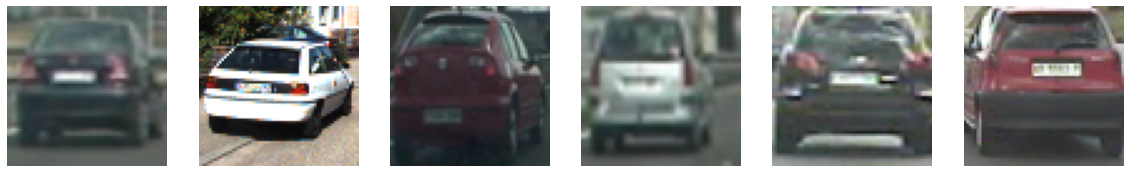

In [6]:
f,axes= plt.subplots(1,6, figsize=(20,20))
temp_v=[]

for index in range(6):
    template= cv2.cvtColor(cv2.imread("./selected_vehicles/"+str(index+1)+".png"),cv2.COLOR_BGR2RGB)
    temp_v.append(template)
    axes[index].imshow(template)
    axes[index].axis("off")

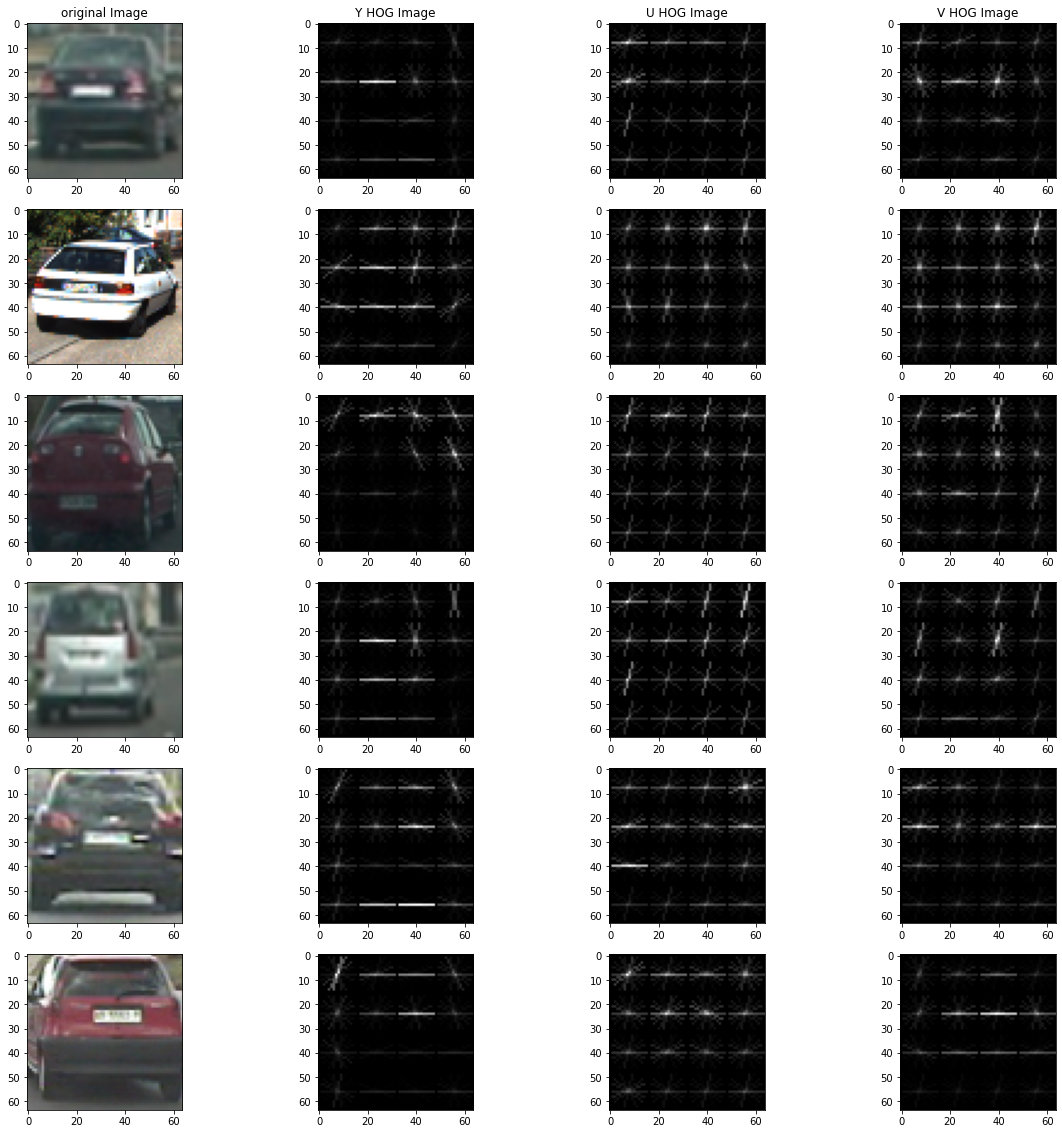

In [7]:
f,axes= plt.subplots(len(temp_v),4, figsize=(20,20))
row=0

axes[row,0].set_title("original Image")
axes[row,1].set_title("Y HOG Image")
axes[row,2].set_title('U HOG Image')
axes[row,3].set_title('V HOG Image')

for temp in temp_v:
    template= cv2.cvtColor(temp,cv2.COLOR_RGB2YUV)

    _ ,hog_image_1 = get_hog_features(template[:,:,0], orient = orient,
                                          cellsPerBlock = cell_per_block,pixelsPerCell = pix_per_cell, 
                                          visualise = True, feature_vector_flag = True)
    
    _ ,hog_image_2 = get_hog_features(template[:,:,1], orient = orient,
                                          cellsPerBlock = cell_per_block,pixelsPerCell = pix_per_cell, 
                                          visualise = True, feature_vector_flag = True)
    
    _ ,hog_image_3 = get_hog_features(template[:,:,2], orient = orient,
                                          cellsPerBlock = cell_per_block,pixelsPerCell = pix_per_cell, 
                                          visualise = True, feature_vector_flag = True)
    
    axes[row,0].imshow(temp)
    axes[row,1].imshow(hog_image_1,  cmap='gray')
    axes[row,2].imshow(hog_image_2,  cmap='gray')
    axes[row,3].imshow(hog_image_3,  cmap='gray')

    row+=1

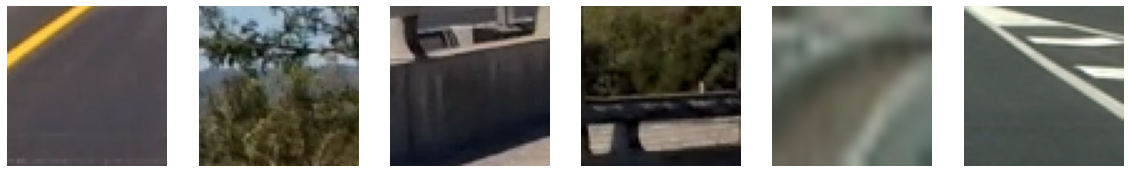

In [8]:
f,axes= plt.subplots(1,6, figsize=(20,20))
temp_nv=[]

for index in range(6):
    template= cv2.cvtColor(cv2.imread("./selected_nonvehicles/"+str(index+1)+".png"),cv2.COLOR_BGR2RGB)
    temp_nv.append(template)
    axes[index].imshow(template)
    axes[index].axis("off")

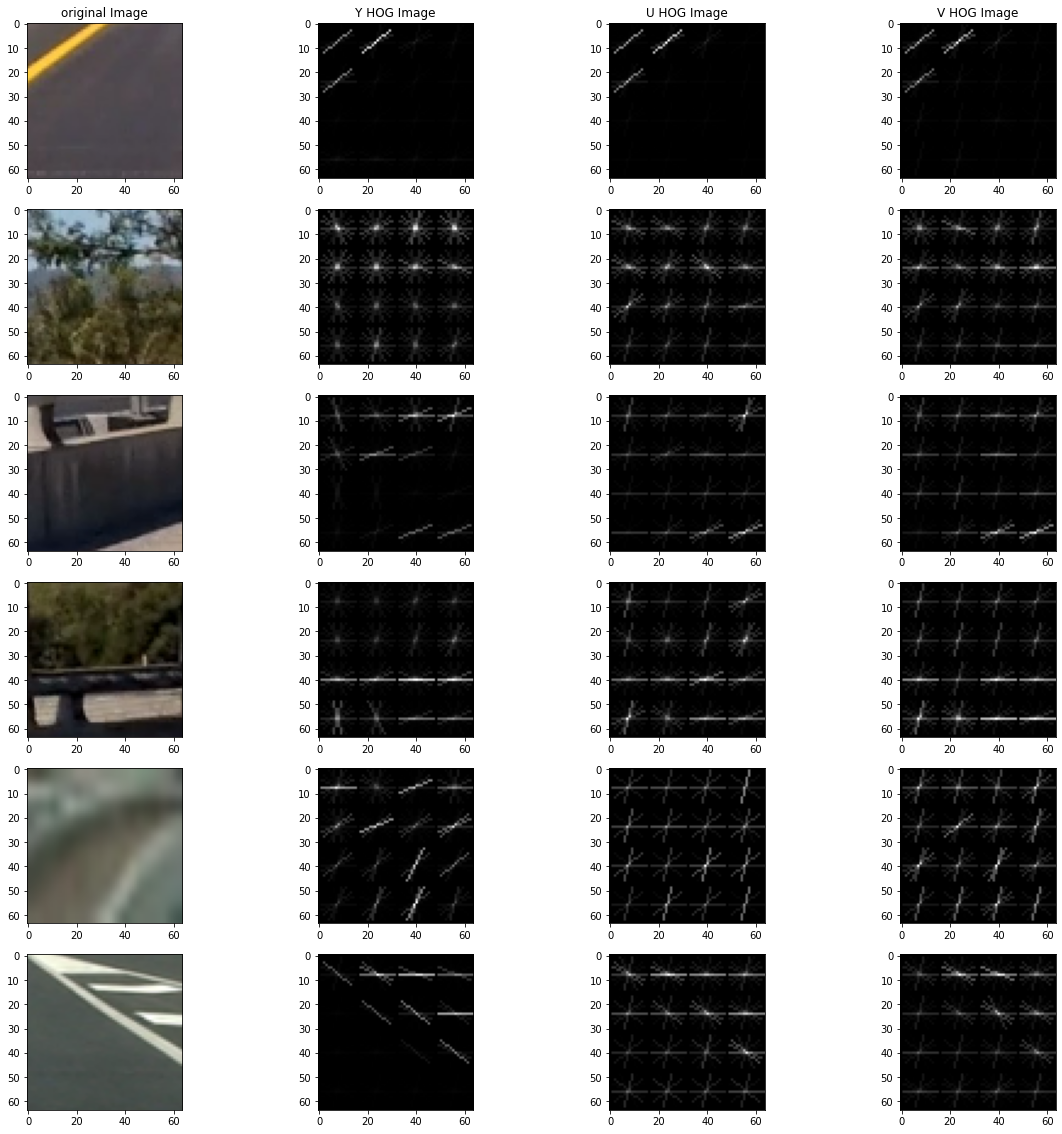

In [9]:
f,axes= plt.subplots(len(temp_nv),4, figsize=(20,20))
row=0

axes[row,0].set_title("original Image")
axes[row,1].set_title("Y HOG Image")
axes[row,2].set_title('U HOG Image')
axes[row,3].set_title('V HOG Image')
    
for temp in temp_nv:
    template= cv2.cvtColor(temp,cv2.COLOR_RGB2YUV)

    _ ,hog_image_1 = get_hog_features(template[:,:,0], orient = orient,
                                          cellsPerBlock = cell_per_block,pixelsPerCell = pix_per_cell, 
                                          visualise = True, feature_vector_flag = True)
    
    _ ,hog_image_2 = get_hog_features(template[:,:,1], orient = orient,
                                          cellsPerBlock = cell_per_block,pixelsPerCell = pix_per_cell, 
                                          visualise = True, feature_vector_flag = True)
    
    _ ,hog_image_3 = get_hog_features(template[:,:,2], orient = orient,
                                          cellsPerBlock = cell_per_block,pixelsPerCell = pix_per_cell, 
                                          visualise = True, feature_vector_flag = True)
    
    axes[row,0].imshow(temp)
    axes[row,1].imshow(hog_image_1,  cmap='gray')
    axes[row,2].imshow(hog_image_2,  cmap='gray')
    axes[row,3].imshow(hog_image_3,  cmap='gray')

    row+=1

In [10]:
def single_extract_features(image_orig, spatial_size, hist_bins, orient, cell_per_block, pix_per_cell,
                        spatial_feat=False, hist_feat=False, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    image_YUV = cv2.cvtColor(image_orig, cv2.COLOR_RGB2YUV)

    spatial_feature = []
    if spatial_feat == True:
        spatial_feature = spatial_features(image_YUV, spatial_size)

    histogram_features=[]
    if hist_feat == True:
        histogram_features = color_hist(image_YUV, hist_bins, hist_range)

    if hog_feat == True:
        local_features_1=get_hog_features(image_YUV[:,:,0], orient = orient,
                                          cellsPerBlock = cell_per_block,pixelsPerCell = pix_per_cell, 
                                          visualise = False, feature_vector_flag = True)
        local_features_2=get_hog_features(image_YUV[:,:,1], orient = orient,
                                          cellsPerBlock = cell_per_block,pixelsPerCell = pix_per_cell, 
                                          visualise = False, feature_vector_flag = True)
        local_features_3=get_hog_features(image_YUV[:,:,2], orient = orient,
                                          cellsPerBlock = cell_per_block,pixelsPerCell = pix_per_cell, 
                                          visualise = False, feature_vector_flag = True)
        hog_features = np.hstack((local_features_1, local_features_2, local_features_3))
        features = np.concatenate((spatial_feature, histogram_features, hog_features))

    return features

In [11]:
def extract_features(imgs, spatial_size, hist_bins,
                        orient, cell_per_block , pix_per_cell, 
                        spatial_feat=False, hist_feat=False, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    for image_orig in imgs:
        single_feature = single_extract_features(image_orig, spatial_size = spatial_size, hist_bins = hist_bins,
                                         orient = orient, cell_per_block = cell_per_block,
                                         pix_per_cell = pix_per_cell,
                                         spatial_feat = spatial_feat, 
                                         hist_feat = hist_feat, hog_feat = hog_feat)
        features.append(single_feature)

    return features

In [12]:
%%time
# if svm classifer exist, load it; otherwise, compute the svm classifier
clf_path = 'clf_pickle_all.p'
if path.isfile(clf_path):
    print('loading existing classifier...')
    with open(clf_path, 'rb') as file:
        clf_pickle = pickle.load(file)
        clf = clf_pickle["clf"]
        X_scaler = clf_pickle["X_scaler"]
        orient = clf_pickle["orient"]
        pix_per_cell = clf_pickle["pix_per_cell"]
        cell_per_block = clf_pickle["cell_per_block"]
        spatial_size = clf_pickle["spatial_size"]
        hist_bins = clf_pickle["hist_bins"]

else:
    # reading image paths with glob
    vehicle_image_arr = glob.glob('./vehicles/*/*.png')

    # read images and append to list
    vehicle_images_original = []
    for imagePath in vehicle_image_arr:
        readImage = cv2.imread(imagePath)
        rgbImage = cv2.cvtColor(readImage, cv2.COLOR_BGR2RGB)
        vehicle_images_original.append(rgbImage)

    print('Reading of Vehicle Images Done')

    non_vehicle_image_arr = glob.glob('./non-vehicles/*/*.png')

    non_vehicle_images_original = []
    for imagePath in non_vehicle_image_arr:
        readImage = cv2.imread(imagePath)
        rgbImage = cv2.cvtColor(readImage, cv2.COLOR_BGR2RGB)
        non_vehicle_images_original.append(rgbImage)

    print("Reading of Non Vehicle Images Done")

    print("No. of Vehicle Images Loaded " + str(len(vehicle_image_arr)))
    print("No. of Non-Vehicle Images Loaded " + str(len(non_vehicle_images_original)))

    print('extraction started')
    vehicleFeatures = extract_features(vehicle_images_original, spatial_size=spatial_size, hist_bins=hist_bins,
                                       orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                                       spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)

    nonVehicleFeatures = extract_features(non_vehicle_images_original, spatial_size=spatial_size, hist_bins=hist_bins,
                                          orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                                          spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)
    print('extraction ended')

    FeaturesList = np.vstack([vehicleFeatures, nonVehicleFeatures])
    print("Shape of Features list is ", FeaturesList.shape)
    LabelList = np.concatenate([np.ones(len(vehicleFeatures)), np.zeros(len(nonVehicleFeatures))])
    print("Shape of Label list is ", LabelList.shape)

    X_train, X_test, Y_train, Y_test = train_test_split(FeaturesList, LabelList, test_size=0.2, shuffle=True)

    X_scaler = StandardScaler()
    X_scaler.fit(X_train)
    X_train_scaled = X_scaler.transform(X_train)
    X_test_scaled = X_scaler.transform(X_test)

    print('Using:', orient, 'orientations', pix_per_cell,
          'pixels per cell and', cell_per_block, 'cells per block')
    print('Feature vector length:', len(X_train[0]))

    print('Training started')
    clf = LinearSVC()
    clf.fit(X_train, Y_train)
    print("Accuracy of SVC is ", clf.score(X_test, Y_test), 4)

    # save classifier
    clf_pickle = {}
    clf_pickle["clf"] = clf
    clf_pickle["X_scaler"] = X_scaler
    clf_pickle["orient"] = orient
    clf_pickle["pix_per_cell"] = pix_per_cell
    clf_pickle["cell_per_block"] = cell_per_block
    clf_pickle["spatial_size"] = spatial_size
    clf_pickle["hist_bins"] = hist_bins

    destnation = clf_path
    pickle.dump(clf_pickle, open(destnation, "wb"))
    print("Classifier is written into: {}".format(destnation))

loading existing classifier...
Wall time: 0 ns


In [13]:
# function to find the windows on which we are going to run the classifier
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None],
                 xy_window=(64, 64), xy_overlap=(0.9, 0.9)):
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]

    window_list = []
    image_width_x = x_start_stop[1] - x_start_stop[0]
    image_width_y = y_start_stop[1] - y_start_stop[0]

    windows_x = np.int(1 + (image_width_x - xy_window[0]) / (xy_window[0] * xy_overlap[0]))
    windows_y = np.int(1 + (image_width_y - xy_window[1]) / (xy_window[1] * xy_overlap[1]))

    modified_window_size = xy_window
    for i in range(0, windows_y):
        y_start = y_start_stop[0] + np.int(i * modified_window_size[1] * xy_overlap[1])
        for j in range(0, windows_x):
            x_start = x_start_stop[0] + np.int(j * modified_window_size[0] * xy_overlap[0])

            x1 = np.int(x_start + modified_window_size[0])
            y1 = np.int(y_start + modified_window_size[1])
            window_list.append(((x_start, y_start), (x1, y1)))
    return window_list

In [14]:
# function to draw sliding Windows
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes

    for bbox in bboxes:
        r = random.randint(0, 255)
        g = random.randint(0, 255)
        b = random.randint(0, 255)
        color = (r, g, b)
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

In [15]:
#defining the Parameters required for the pipeline to run
image = mpimg.imread('./test_images/test1.jpg')
xy_window=(64, 64) # window Size
xy_overlap=(0.15, 0.15) # Window Overlap. Please note this is different as provided by Udacity. Overlap of 0.15 means my windows are 85% overlapping with each other
x_start_stop=[0, image.shape[1]] # X Coordinates to start and stop search
y_start_stop=[400, 660] # Y Coordinates to start and stop search

# Window 1- Size - 64x64 , Overlap-85%
windows_normal = slide_window(image, x_start_stop, [400,464],
                    xy_window, xy_overlap)

# Window 2- Size - 80x80 , Overlap-80%
xy_window_1_25= (80,80)
xy_window_1_25_overlap=(0.2, 0.2)
windows_1_25 = slide_window(image, x_start_stop, [400,480],
                    xy_window_1_25, xy_window_1_25_overlap)

# Window 3- Size - 96x96 , Overlap-70%
xy_window_1_5= (96,96)
xy_window_1_5_overlap=(0.3, 0.3)
windows_1_5 = slide_window(image, x_start_stop, [400,612],
                    xy_window_1_5, xy_window_1_5_overlap)

# Window 4- Size - 128x128 , Overlap-50%
xy_window_twice_overlap=(0.5, 0.5)
xy_window_twice = (128,128)
windows_twice = slide_window(image, x_start_stop, [400,660],
                    xy_window_twice, xy_window_twice_overlap)

# Total Windows - 470
windows= windows_normal +  windows_1_5  + windows_twice +windows_1_25
print("No of Windows are ", len(windows))

No of Windows are  470


In [16]:
# function that returns the refined Windows
# From Refined Windows we mean that the windows where the classifier predicts the output to be a car
def DrawCars(image, windows):
    refinedWindows = []
    for window in windows:

        start = window[0]
        end = window[1]
        clippedImage = image[start[1]:end[1], start[0]:end[0]]

        if (clippedImage.shape[1] == clippedImage.shape[0] and clippedImage.shape[1] != 0):

            clippedImage = cv2.resize(clippedImage, (64, 64))

            f = single_extract_features(clippedImage, spatial_size = spatial_size, hist_bins = hist_bins,
                                         orient = orient, cell_per_block = cell_per_block,
                                         pix_per_cell = pix_per_cell,
                                         spatial_feat = spatial_feat, 
                                         hist_feat = hist_feat, hog_feat = hog_feat)

            predictedOutput = clf.predict([f])
            if (predictedOutput == 1):
                refinedWindows.append(window)

    return refinedWindows

In [17]:
# function to increase the pixel by one inside each box
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

In [18]:
# applying a threshold value to the image to filter out low pixel cells
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

In [19]:
# find pixels with each car number and draw the final bounding boxes
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,255,0), 6)
    # Return the image
    return img

 Number of Cars found -  0
 Number of Cars found -  1
 Number of Cars found -  2
 Number of Cars found -  0
 Number of Cars found -  0
 Number of Cars found -  2
 Number of Cars found -  2
 Number of Cars found -  2


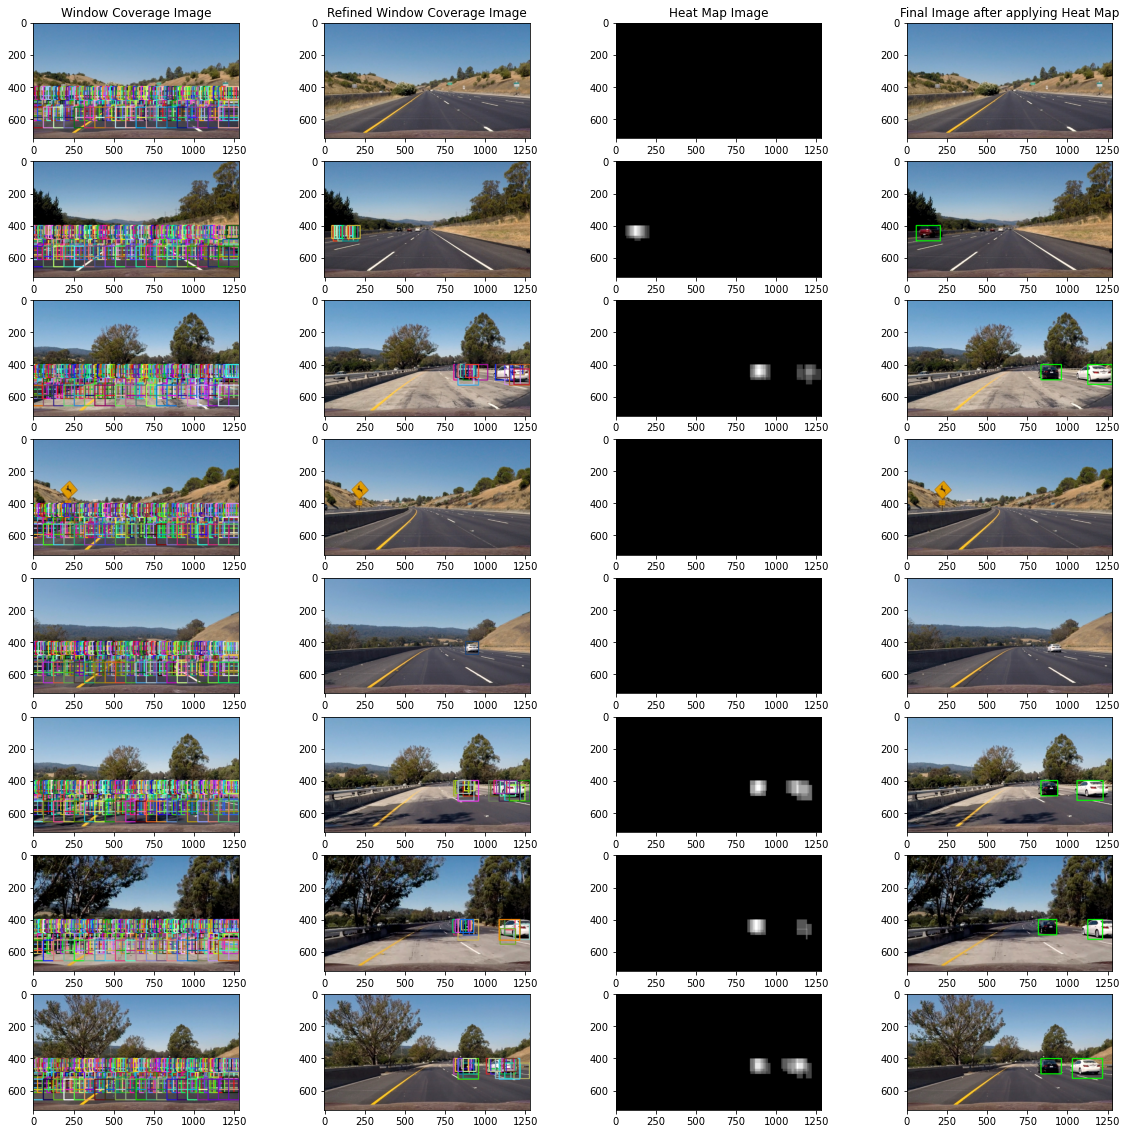

In [20]:
f,axes= plt.subplots(8,4, figsize=(20,20))
temp_test=[]

# reading image paths with glob
test_image_arr = glob.glob('./test_images/*.jpg')

for imagePath in test_image_arr:
    readImage = cv2.imread(imagePath)
    rgbImage = cv2.cvtColor(readImage,cv2.COLOR_BGR2RGB)
    temp_test.append(rgbImage)
    
row = 0

axes[row,0].set_title("Window Coverage Image")
axes[row,1].set_title("Refined Window Coverage Image")
axes[row,2].set_title("Heat Map Image")
axes[row,3].set_title("Final Image after applying Heat Map")

for img in temp_test:
    window_img = draw_boxes(img, windows) 

    refinedWindows = DrawCars(img, windows)
    ref_window_img = draw_boxes(img, refinedWindows) 

    #testing our heat function
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    heat = add_heat(heat,refinedWindows)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,2)

    # Visualize the heatmap when displaying    
    heat_image = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heat_image)
    print(" Number of Cars found - ",labels[1])
    draw_img = draw_labeled_bboxes(np.copy(img), labels)

    axes[row,0].imshow(window_img)
    axes[row,1].imshow(ref_window_img)
    axes[row,2].imshow(heat_image,cmap='gray')
    axes[row,3].imshow(draw_img)
    
    row += 1

In [21]:
# Defining a different pipeline to process the images as we do not want to keep track of previous frames here
def PipelineImage(image):  
    img = np.copy(image)
    refinedWindows = DrawCars(img, windows)
    ref_window_img = draw_boxes(img, refinedWindows) 
    
    heat = np.zeros_like(img[:, :, 0]).astype(np.float)
    heat = add_heat(heat, refinedWindows)

    heat_image = np.clip(heat, 0, 255)
    heat_image = apply_threshold(heat, 2)
    
    labels = label(heat_image)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    
    return ref_window_img, heat_image, draw_img

In [22]:
# Defining a class to store the refined frames found from the last 15 frames
class KeepTrack():
    def __init__(self):
        self.refinedWindows = [] 
        
    def AddWindows(self, refinedWindow):
        self.refinedWindows.append(refinedWindow)
        frameHistory=15
        if len(self.refinedWindows) > frameHistory:
            self.refinedWindows = self.refinedWindows[len(self.refinedWindows)-frameHistory:]


In [23]:
# Defining a pipeline for Video Frame Processing
# The last 15 frames is kept
def Pipeline(image):
    rand= random.randint(0,1)
    if(rand<0.4):
        refinedWindows=keepTrack.refinedWindows[:-1]
    else:
        refinedWindows=DrawCars(image,windows)
        if len(refinedWindows) > 0:
            keepTrack.AddWindows(refinedWindows)
            
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    
    for refinedWindow in keepTrack.refinedWindows:
        heat = add_heat(heat, refinedWindow)
    
    heatmap = apply_threshold(heat, 21 + len(keepTrack.refinedWindows)//2)
    
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    return draw_img

In [24]:
keepTrack = KeepTrack()
video_output = './output_videos/VD_project_video_v4.mp4'
video_input = VideoFileClip('./test_videos/project_video.mp4')
processed_video = video_input.fl_image(Pipeline)
%time processed_video.write_videofile(video_output, audio=False)
video_input.reader.close()
video_input.audio.reader.close_proc()

Moviepy - Building video VD_project_video_v2.mp4.
Moviepy - Writing video VD_project_video_v2.mp4



Moviepy - Done !
Moviepy - video ready VD_project_video_v2.mp4
Wall time: 13min 30s
